In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim, n_classes, img_shape, normalize=True):
        #img shape:(C, H, W)
        super().__init__()
        self.img_shape = img_shape
        self.out_dim = np.prod(img_shape)
        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_dim, out_dim, normalize=normalize):
            layers = [nn.Linear(in_dim, out_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, self.out_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        #z shape: (N, latent_dim)
        #label_input shape: (N, n_classes)
        #x shape: (N, latent_dim + n_classes)
        label_input = self.label_emb(labels)
        x = torch.cat((z, label_input), dim=1)
        img = self.model(x)
        img = img.view(img.size(0), *self.img_shape)
        return img


In [3]:
class Discriminator(nn.Module):
    def __init__(self, n_classes, img_shape):
        super().__init__()
        in_dim = np.prod(img_shape)
        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(in_dim + n_classes, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels)
        img_flat = img.view(img.size(0), -1)
        x = torch.cat((img_flat, label_input), dim=1)
        validity = self.model(x)
        return validity

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1024
lr = 0.0002
latent_dim = 100
n_classes = 10
img_shape = (1, 28, 28)
n_epochs = 1001
G_losses = []
D_losses = []
test_z = torch.randn(10, latent_dim).to(device)
test_label = torch.arange(10).to(device)

In [5]:
generator = Generator(latent_dim, n_classes, img_shape).to(device)
discriminator = Discriminator(n_classes, img_shape).to(device)
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]) #value between [-1, 1]
dataset = datasets.MNIST(root='../../datasets', train=True, download=True, transform=transform)
x = torch.stack([img for img, _ in dataset]).to(device)
y = torch.stack([torch.tensor(label) for _, label in dataset]).to(device)
dataset_gpu = TensorDataset(x, y)
dataloader = DataLoader(dataset_gpu, batch_size=batch_size, shuffle=True)

[Epoch 0/1001] D Loss: 1.2254 G Loss: 0.8460


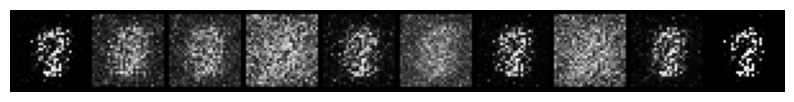

[Epoch 100/1001] D Loss: 1.2460 G Loss: 0.9691


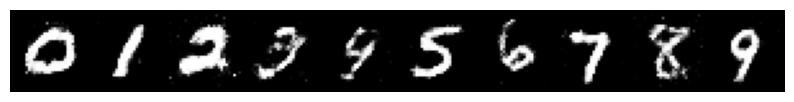

[Epoch 200/1001] D Loss: 1.2320 G Loss: 1.0079


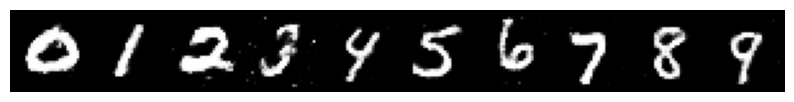

[Epoch 300/1001] D Loss: 1.1303 G Loss: 1.1998


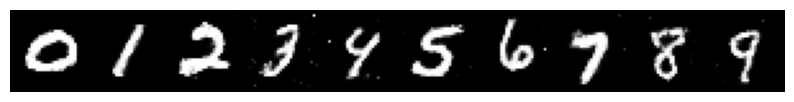

[Epoch 400/1001] D Loss: 0.9992 G Loss: 1.4748


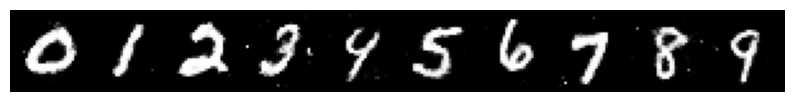

[Epoch 500/1001] D Loss: 0.8583 G Loss: 1.8311


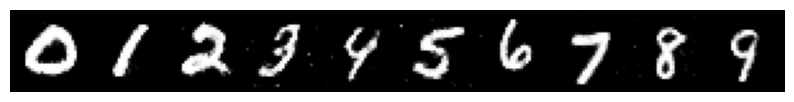

[Epoch 600/1001] D Loss: 0.7836 G Loss: 2.0486


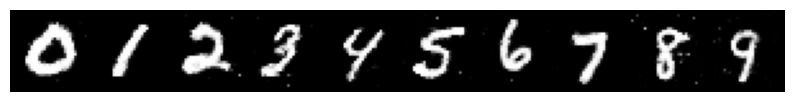

[Epoch 700/1001] D Loss: 0.6299 G Loss: 2.4964


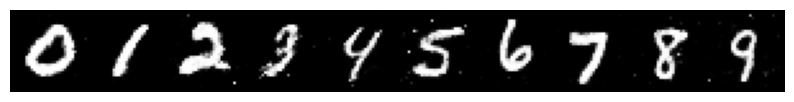

[Epoch 800/1001] D Loss: 0.6555 G Loss: 2.8076


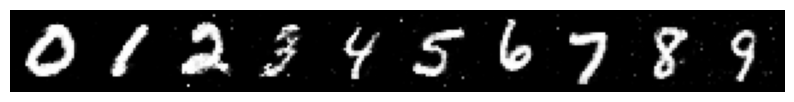

[Epoch 900/1001] D Loss: 0.4907 G Loss: 3.0614


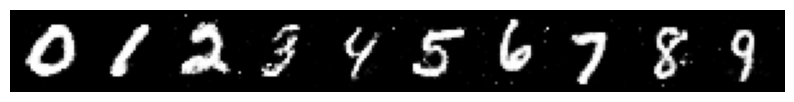

[Epoch 1000/1001] D Loss: 0.4879 G Loss: 3.3677


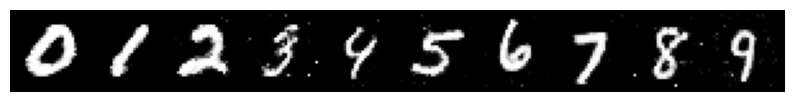

In [7]:
for epoch in range(n_epochs):
    generator.train()
    discriminator.train()
    epoch_g_loss = 0
    epoch_d_loss = 0
    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size_curr = real_imgs.size(0)
        labels = labels.to(device)

        real_labels = torch.ones(batch_size_curr, 1).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)

        #Train Discriminator
        real_output = discriminator(real_imgs, labels)
        d_loss_real = criterion(real_output, real_labels)

        z = torch.randn(batch_size_curr, latent_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (batch_size_curr,), device=device)
        fake_imgs = generator(z, gen_labels)
        fake_output = discriminator(fake_imgs.detach(), gen_labels)
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        #Train Generator
        fake_output = discriminator(fake_imgs, gen_labels)
        g_loss = criterion(fake_output, real_labels)
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        epoch_g_loss += g_loss.detach().cpu().item() * batch_size_curr
        epoch_d_loss += d_loss.detach().cpu().item() * batch_size_curr
    
    G_losses.append(epoch_g_loss / len(dataset))
    D_losses.append(epoch_d_loss / len(dataset))
    if epoch % 100 == 0:
        print(f"[Epoch {epoch}/{n_epochs}] D Loss: {(epoch_d_loss / len(dataset)):.4f} G Loss: {(epoch_g_loss / len(dataset)):.4f}")
        
        generator.eval()
        with torch.no_grad():
            generated = generator(test_z, test_label).detach().cpu()
            grid = make_grid(generated, nrow=10, normalize=True)
            plt.figure(figsize=(10, 10))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis('off')
            plt.show()